In [ ]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns

# 그래프 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 기본 설정 

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 


plt.rc("font", family = "DejaVu Sans") # 우분투 기본폰트
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# 기본 작업 경로 설정
import os
notebook_path = os.path.abspath("project_3_git/code/2_YOLO_finetunning.ipynb")
notebook_dir = os.path.dirname(notebook_path)
os.chdir(notebook_dir)

# 현재 작업 디렉토리 출력
print("Current working directory: ", os.getcwd())

Current working directory:  /mnt/e/py_data/project_3_git/code


In [4]:
import json

def openjson(path):

    with open(path, encoding="cp949") as f:
        data = json.load(f)
    return data

trainjsons = []
testjsons  = []
validjsons = []

trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_anger.json')])
trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_happy.json')])
trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_panic.json')])
trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_sadness.json')])

validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_anger.json')])
validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_happy.json')])
validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_panic.json')])
validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_sadness.json')])

testjsons.extend([i for i in openjson('../data/image_data/test/label/test_anger.json')])
testjsons.extend([i for i in openjson('../data/image_data/test/label/test_happy.json')])
testjsons.extend([i for i in openjson('../data/image_data/test/label/test_panic.json')])
testjsons.extend([i for i in openjson('../data/image_data/test/label/test_sadness.json')])

In [5]:
train_directory_path = '../data/image_data/train/img/train/'
valid_directory_path = '../data/image_data/train/img/val/'
test_directory_path = '../data/image_data/test/image/'


In [6]:
import os

def find_images(root_dir):
    # 이미지 확장자 목록
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    
    image_files = []
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_files.append(os.path.join(root, file))
    
    return image_files

paths_train = find_images(train_directory_path)
paths_valid = find_images(valid_directory_path)
paths_test = find_images(test_directory_path)

### yolo v10 의 어노테이션 이해
- yaml 파일 이해
    data.yaml
    
    ```text
    train: ../train/images
    val: ../valid/images

    nc: 3
    names: ['head', 'helmet', 'person']
    ```

- txt 파일
    
    ```class_id center_x center_y width height```
    ```text
    1 0.617 0.3594420600858369 0.114 0.17381974248927037
    1 0.094 0.38626609442060084 0.156 0.23605150214592274
    1 0.295 0.3959227467811159 0.13 0.19527896995708155
    ```

In [7]:
# train 어노테이션 만들기 포 욜로10
import cv2
import os

# 클래스 이름을 클래스 ID로 매핑하는 딕셔너리
class_names = ['anger', 'sad', 'panic', 'happy']
class_to_id = {name: idx for idx, name in enumerate(class_names)}

def convert_bbox_to_yolo_format(image_size, bbox):
    """
    바운딩 박스를 YOLO 형식으로 변환.
    :param image_size: (width, height) 이미지 크기
    :param bbox: {'minX': float, 'minY': float, 'maxX': float, 'maxY': float} 바운딩 박스 좌표
    :return: (x_center, y_center, width, height) YOLO 형식의 바운딩 박스
    """
    dw = 1.0 / image_size[0]
    dh = 1.0 / image_size[1]
    x_center = (bbox['minX'] + bbox['maxX']) / 2.0
    y_center = (bbox['minY'] + bbox['maxY']) / 2.0
    width = bbox['maxX'] - bbox['minX']
    height = bbox['maxY'] - bbox['minY']
    
    # YOLO 형식에 맞게 좌표를 정규화
    x_center = x_center * dw
    y_center = y_center * dh
    width = width * dw
    height = height * dh
    
    return (x_center, y_center, width, height)

def save_annotations(json_data, output_dir, image_size):
    """
    이미지를 yolo 에 맞게
    txt 파일 생성 (위의 함수를 불러와 형식 변환 후 저장.)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for item in json_data:
        image_file = item['filename']
        image_name, _ = os.path.splitext(image_file)
        txt_file_path = os.path.join(output_dir, f"{image_name}.txt")
        
        with open(txt_file_path, 'w') as f:
            # Iterate over annotations (A, B, C)
            annot = item.get('annot_A')
            print(annot)
            if annot:
                bbox = annot['boxes']
                face_exp = item['faceExp_uploader']
                class_id = class_to_id.get(face_exp, -1)
                if class_id == -1:
                    class_id = 3
                print(class_id)
                if class_id != -1:
                    yolo_bbox = convert_bbox_to_yolo_format(image_size, bbox)
                    print(yolo_bbox)
                    f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")
                    print(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")


In [8]:
output_directory = '../data/yolo_data/./train/'

for i in paths_train:
    name_of_file = (i.split('/')[-1].split('.')[0])
    for j in trainjsons:
        if name_of_file in j['filename']:

            # Check if annotation file already exists before saving
            image_file = j['filename']
            image_name, _ = os.path.splitext(image_file)
            txt_file_path = os.path.join(output_directory, f"{image_name}.txt")
            
            if not os.path.exists(txt_file_path):
                image = cv2.imread(i)
                h, w, _ = image.shape
                # 상대 위치로 결정되기 때문에 파일 크기가 필요하다
                image_size = (w, h)
                print(name_of_file)
                print(image_size)
                print(j['annot_A']['boxes'])
                save_annotations([j], output_directory, image_size)
                print('')
            else:
                print(f"Annotation file already exists: {txt_file_path}")


In [9]:
output_directory = '../data/yolo_data/./val/'

for i in paths_valid:
    name_of_file = (i.split('/')[-1].split('.')[0])
    for j in validjsons:
        if name_of_file in j['filename']:

            # Check if annotation file already exists before saving
            image_file = j['filename']
            image_name, _ = os.path.splitext(image_file)
            txt_file_path = os.path.join(output_directory, f"{image_name}.txt")
            
            if not os.path.exists(txt_file_path):
                image = cv2.imread(i)
                h, w, _ = image.shape
                # 상대 위치로 결정되기 때문에 파일 크기가 필요하다
                image_size = (w, h)
                print(name_of_file)
                print(image_size)
                print(j['annot_A']['boxes'])
                save_annotations([j], output_directory, image_size)
                print('')
            else:
                print(f"Annotation file already exists: {txt_file_path}")


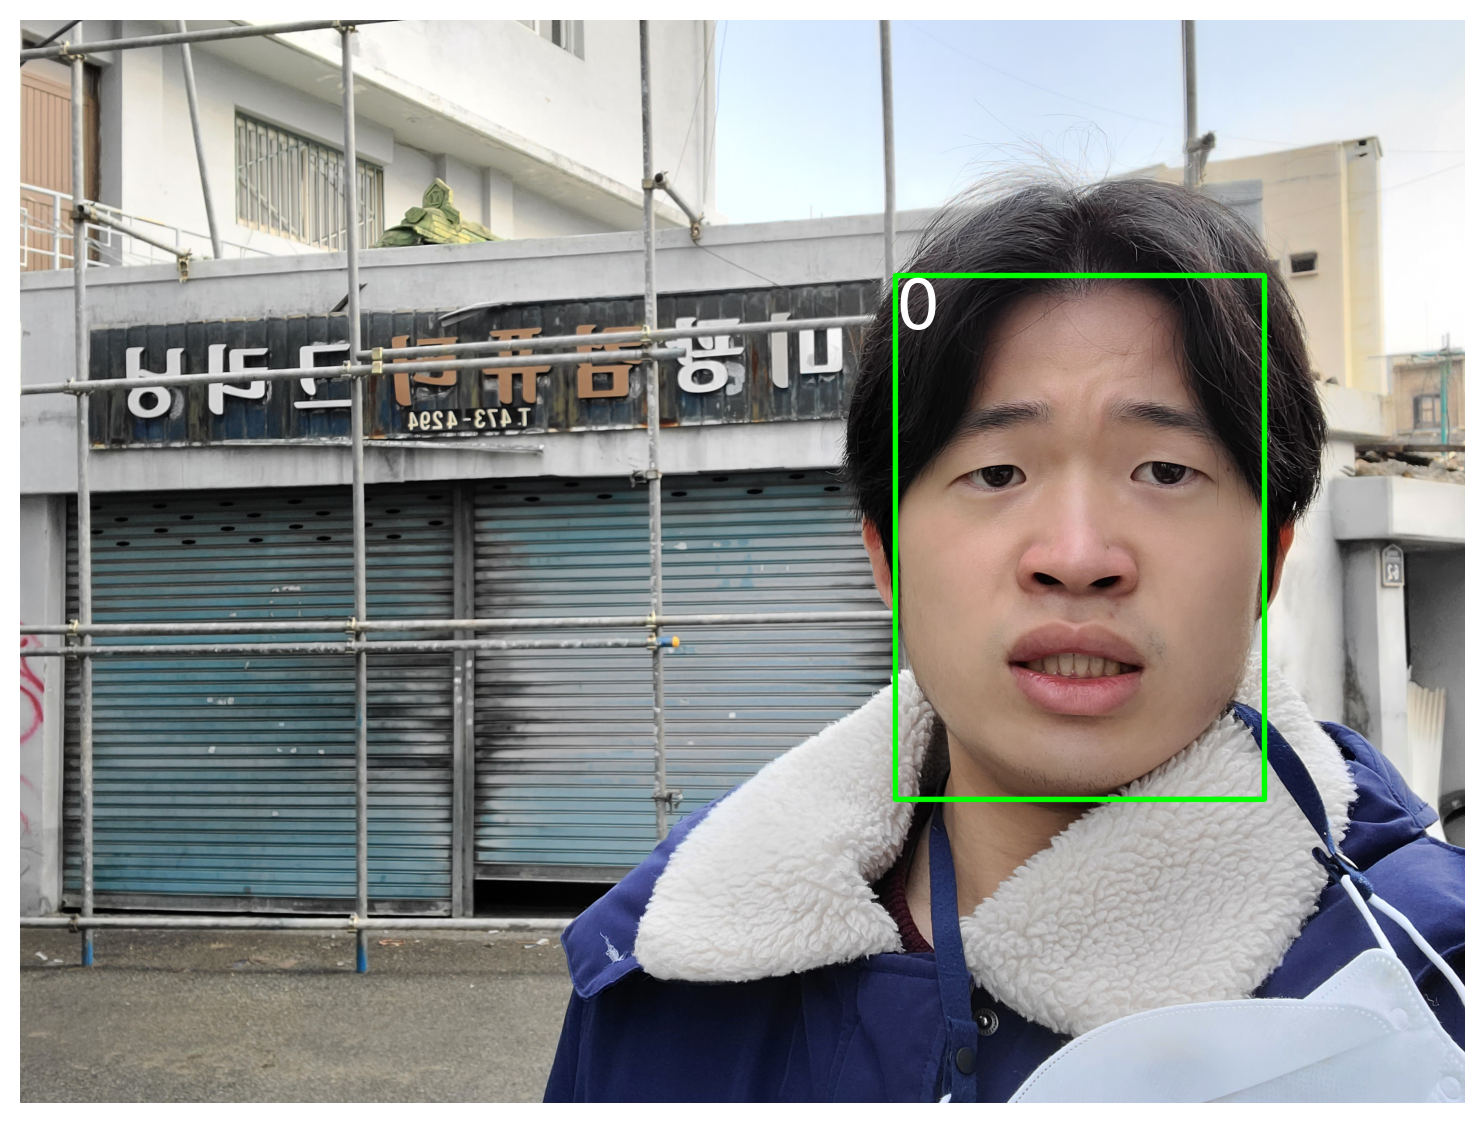

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_yolo_to_bbox(image_size, yolo_bbox):
    """
    욜로 상대 좌표(점과 크기) 에서 절대 좌표로 변환
    """
    img_height, img_width = image_size
    x_center, y_center, width, height = yolo_bbox
    
    # Convert from relative coordinates to absolute coordinates
    x_center_abs = x_center * img_width
    y_center_abs = y_center * img_height
    width_abs = width * img_width
    height_abs = height * img_height
    
    # Calculate min and max coordinates
    minX = int(x_center_abs - (width_abs / 2.0))
    minY = int(y_center_abs - (height_abs / 2.0))
    maxX = int(x_center_abs + (width_abs / 2.0))
    maxY = int(y_center_abs + (height_abs / 2.0))
    
    return minX, minY, maxX, maxY

path_test_img = '../data/yolo_data/train/'
name = 'jwaccb50afa0212a340d07cd6204f4cd10aa5ab0b162c162a57f11431f7d3kdhp'
image = cv2.imread(path_test_img + name +'.jpg')
h, w ,_ = image.shape
label_path = path_test_img + name + '.txt'
with open(label_path, 'r') as f:
    label__ =  f.read().split()

label__ = [float(i) for i in  label__]

recovered_pic_bb = convert_yolo_to_bbox((h,w),label__[1:])

minX, minY, maxX, maxY = recovered_pic_bb

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.rectangle(image_rgb, (minX, minY), (maxX, maxY), (0, 255, 0), 10)
plt.axis('off')

plt.imshow(image_rgb)

plt.text(minX, minY, int(label__[0]), color='white', fontsize=25,
         ha='left', va='top')


plt.show()